# Analysis of Kernel Features

This notebook analyzes the results of the static analysis of CUDA kernels, showing the distribution of various features.

In [11]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
# Load the classification results
with open('classification_results.json', 'r') as f:
    data = json.load(f)

In [13]:
# Extract the feature counts
feature_counts = {
    "Float Division": 0,
    "External Function Calls": 0,
    "Recursion": 0,
    "Warp Divergence": 0,
    "Data-Dependent Warp Divergence": 0,
    "Common Subexpression": 0,
    "Special Math Function": 0
}

for targetName, file_dict in data.items():
    for filename, kernels in file_dict.items():
        for kernel in kernels:
            result = kernel
            if result['has_float_division']:
                feature_counts["Float Division"] += 1
            if result['has_external_function_calls']:
                feature_counts["External Function Calls"] += 1
            if result['has_recursion']:
                feature_counts["Recursion"] += 1
            if result['has_warp_divergence']:
                feature_counts["Warp Divergence"] += 1
            if result['has_data_dependent_warp_divergence']:
                feature_counts["Data-Dependent Warp Divergence"] += 1
            if result['has_common_subexpression']:
                feature_counts["Common Subexpression"] += 1
            if result['has_special_math_function']:
                feature_counts["Special Math Function"] += 1

df = pd.DataFrame(list(feature_counts.items()), columns=['Feature', 'Count'])
df = df.sort_values(by='Count', ascending=False)

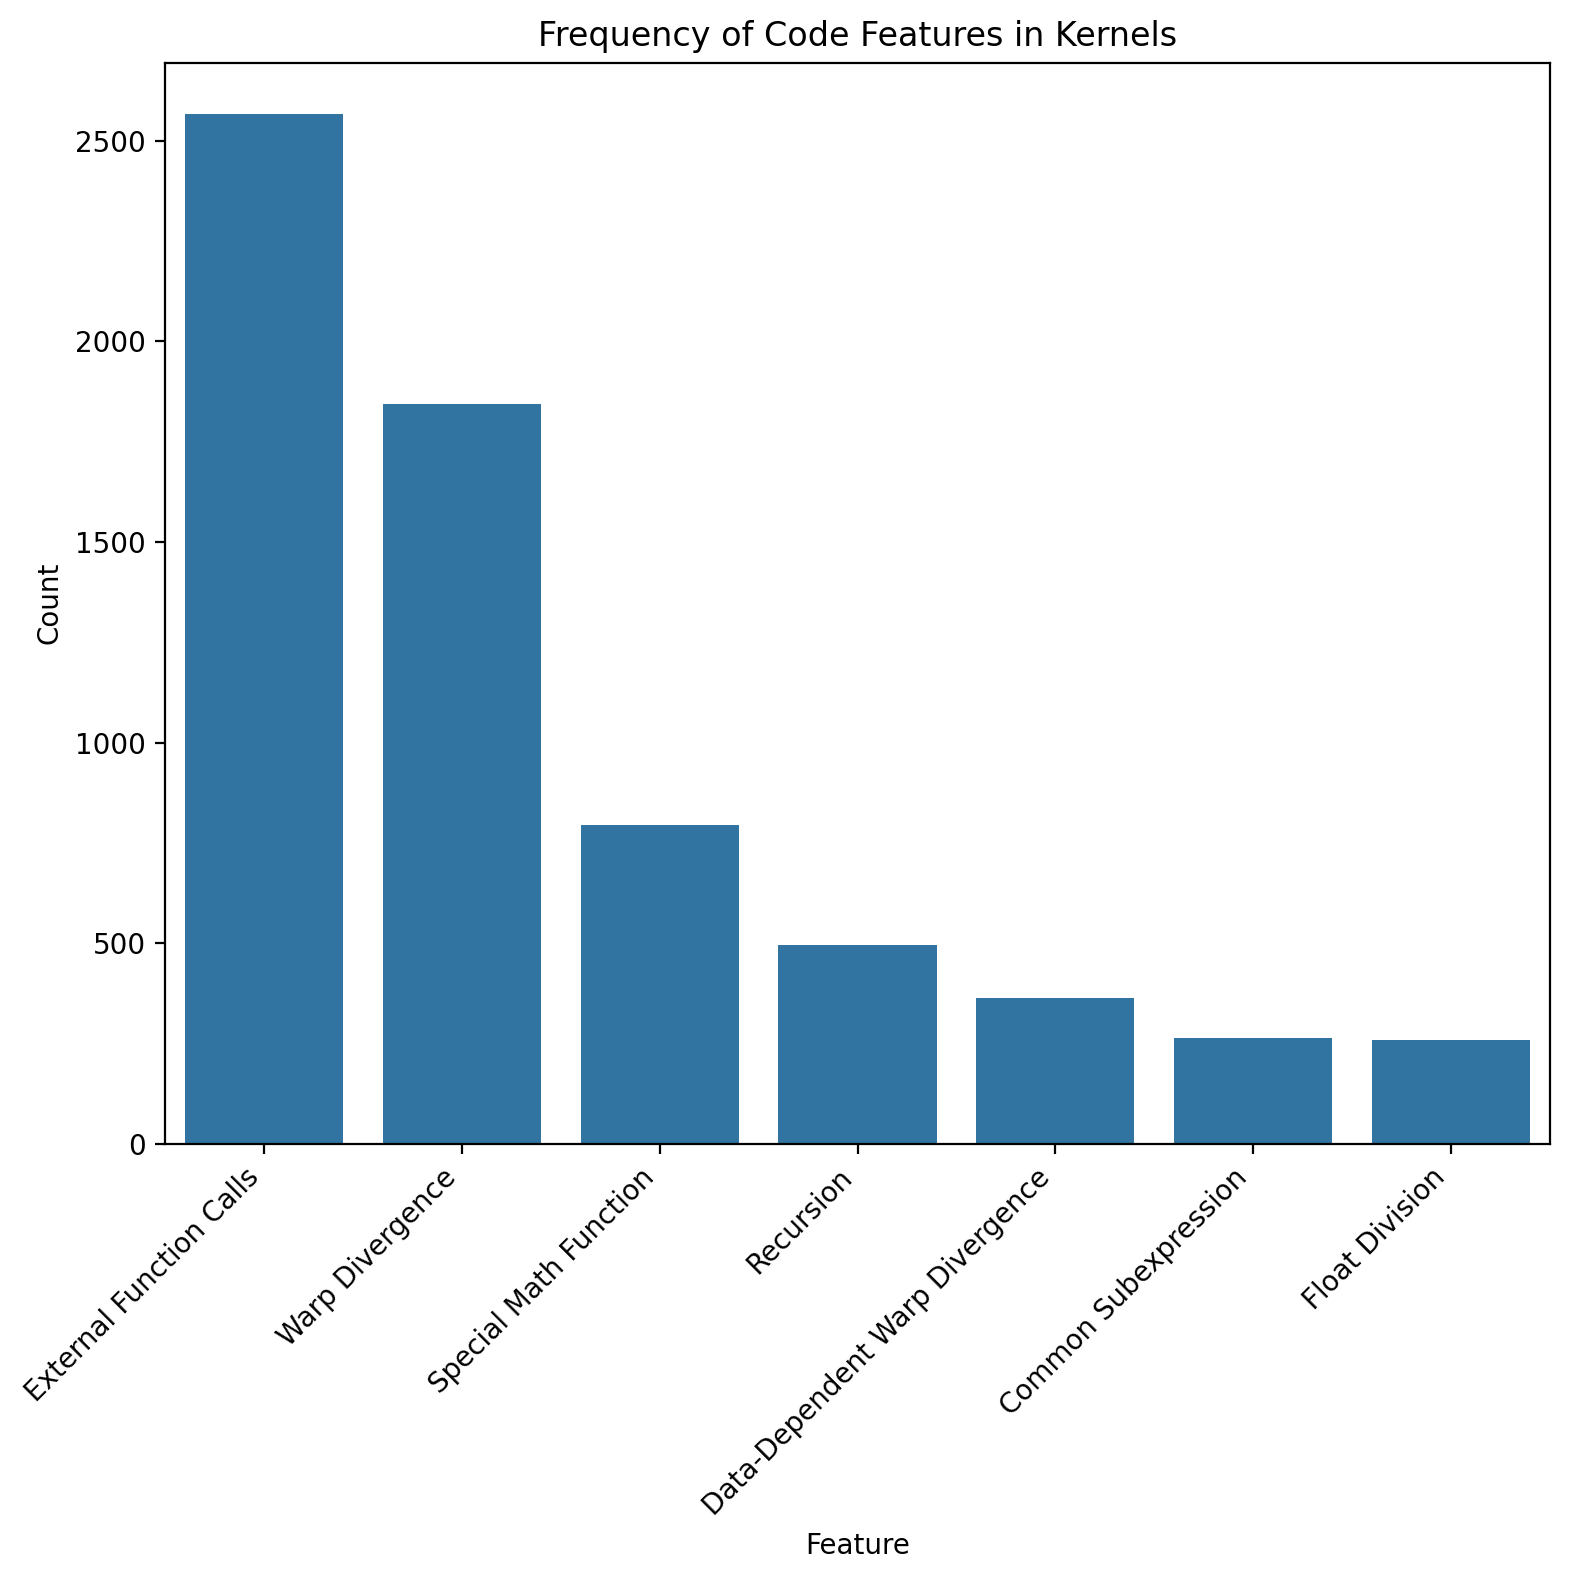

In [17]:
# Create the histogram
plt.figure(figsize=(8, 8), dpi=200)
sns.barplot(x='Feature', y='Count', data=df)
plt.title('Frequency of Code Features in Kernels')
plt.xlabel('Feature')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()